# Inpainting di immagini satellitari

Il progetto riguarda il inpainting (ritocco) di immagini, che consiste nel riempire parti deteriorate o mancanti di un'immagine per ricostruire un'immagine completa.

Il dataset preso in considerazione è il dataset EuroSAT di tensorflow basato su immagini satellitari Sentinel-2, nella versione rgb. Questo comprende 27000 immagini, a risoluzione 64x64.

Una porzione dell'immagine viene mascherata casualmente secondo la procedura descritta di seguito. Il tuo obiettivo è ricostruire l'immagine completa.



In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras import layers, models,optimizers

Il Downloading e la preparazione del dataset possono richiedere alcuni minuti

In [ ]:
ds_train, ds_info = tfds.load(
    'eurosat/rgb',
    shuffle_files=False,
    #as_supervised=True,  # Returns a tuple (img, label) instead of a dictionary {'image': img, 'label': label}
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteYDN2II/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_train = ds_train['train']

In [ ]:
ds_train = ds_train.shuffle(1000, seed = 42)

In [ ]:
train_dataset = ds_train.take(20000)
test_dataset = ds_train.skip(20000)

Il generatore fornisce i vostri dati di addestramento. Creiamo una maschera disegnando linee verticali casuali con angoli diversi e con larghezza variabile. La porzione dell'immagine conservata è quella sotto la maschera.

In [ ]:
def generator(dataset,nolines=9):
    while True:  # Start an infinite loop
        for batch in dataset:
            images = batch["image"]
            images_np = images.numpy()

            masks = np.zeros((batch_size, 64, 64))
            for i in range(batch_size):
                for j in range(nolines):
                    start_point = (np.random.randint(0, 64 - 1), 0)
                    end_point = (np.random.randint(0, 64 - 1), 63)
                    thickness = np.random.randint(2, 3)
                    masks[i] = cv2.line(masks[i], start_point, end_point, (1), thickness)

            images_np = images_np / 255.0
            masks = np.stack(((masks),) * 3, axis=-1)

            yield (images_np * masks, images_np)

# Batch the datasets
batch_size = 8
train_dataset_batched = train_dataset.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)

# Create generators for the batched datasets
train_generator = generator(train_dataset_batched)
test_generator = generator(test_dataset_batched)

# Archiettura e scelte implementative
L'architettura della rete che ho realizzato è una variante della U-Net, una rete neurale convoluzionale (CNN) comunemente utilizzata per la segmentazione e l'inpainting di immagini. Di seguito sono riportate alcune caratteristiche chiave e commenti sulle scelte implementative:

1. **Encoder:**
   - Il layer di input riceve immagini con forma `(64, 64, 3)`.
   - Due blocchi convoluzionali (Conv2D) con 64 filtri ciascuno e attivazione ReLU vengono applicati. Ogni blocco è seguito da Batch Normalization per accelerare la convergenza della rete.
   - Viene applicato un layer di Excitation per catturare le caratteristiche più rilevanti. Questo strato calcola la media globale delle feature map e applica un meccanismo di "eccitazione" per enfatizzare le caratteristiche più importanti. Il risultato è moltiplicato per la feature map originale.
   - Viene applicato un layer di MaxPooling per ridurre la dimensione delle feature map.

2. **Decoder:**
   - Due blocchi convoluzionali con 128 filtri ciascuno vengono applicati, seguiti da Batch Normalization.
   - Viene introdotto uno strato di Inception, che combina la feature map dal blocco decoder precedente con una feature map derivata da un blocco convoluzionale separato.
   - Viene applicato un layer di UpSampling per aumentare le dimensioni delle feature map.

3. **Output Layer:**
   - Viene applicato un ulteriore blocco convoluzionale con 64 filtri, seguito da un layer di output con 3 filtri e attivazione sigmoide. Questo strato è progettato per produrre l'output finale dell'inpainting con tre canali (RGB) e valori compresi tra 0 e 1.

4. **Model Compilation:**
   - Il modello viene compilato utilizzando l'ottimizzatore Adam, una funzione di perdita basata sull'errore quadratico medio (`mean_squared_error`), e la metrica di accuratezza.



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet(input_shape):
    # Encoder
    inputs = tf.keras.Input(shape=input_shape)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)

    # Excitation Layer
    excitation1 = layers.GlobalAveragePooling2D()(conv1)
    excitation1 = layers.Reshape((1, 1, 64))(excitation1)
    excitation1 = layers.Conv2D(64, 1, activation='sigmoid', use_bias=False)(excitation1)
    excitation1 = layers.Multiply()([conv1, excitation1])

    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(excitation1)

    # Decoder
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)

    # Inception Layer
    inception2 = layers.Conv2D(64, 1, activation='relu')(pool1)
    inception2 = layers.Conv2D(128, 3, activation='relu', padding='same')(inception2)
    inception2 = layers.Concatenate()([conv2, inception2])

    up1 = layers.UpSampling2D(size=(2, 2))(inception2)
    up1 = layers.Conv2D(64, 3, activation='relu', padding='same')(up1)

    # Output layer
    output = layers.Conv2D(3, 1, activation='sigmoid')(up1)

    model = models.Model(inputs=inputs, outputs=output)
    return model

# Crea il modello U-Net
input_shape = (64, 64, 3)
inpainting_model = build_unet(input_shape)

# Compila il modello
inpainting_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])




In [ ]:
# Addestra il modello
epochs = 20
steps_per_epoch = len(train_dataset) // batch_size
validation_steps = len(test_dataset) // batch_size

history=inpainting_model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                     validation_data=test_generator, validation_steps=validation_steps)


Epoch 1/20
2500/2500 [==============================] - 64s 22ms/step - loss: 0.0048 - accuracy: 0.8122 - val_loss: 0.0035 - val_accuracy: 0.8498
Epoch 2/20
2500/2500 [==============================] - 83s 33ms/step - loss: 0.0034 - accuracy: 0.8602 - val_loss: 0.0033 - val_accuracy: 0.8777
Epoch 3/20
2500/2500 [==============================] - 52s 21ms/step - loss: 0.0032 - accuracy: 0.8697 - val_loss: 0.0031 - val_accuracy: 0.8511
Epoch 4/20
2500/2500 [==============================] - 77s 31ms/step - loss: 0.0031 - accuracy: 0.8769 - val_loss: 0.0030 - val_accuracy: 0.8227
Epoch 5/20
2500/2500 [==============================] - 123s 49ms/step - loss: 0.0030 - accuracy: 0.8826 - val_loss: 0.0031 - val_accuracy: 0.8649
Epoch 6/20
2500/2500 [==============================] - 46s 18ms/step - loss: 0.0030 - accuracy: 0.8846 - val_loss: 0.0033 - val_accuracy: 0.8802
Epoch 7/20
2500/2500 [==============================] - 82s 27ms/step - loss: 0.0029 - accuracy: 0.8882 - val_loss: 0.0029 

Visualizziamo i dati. Nella prima riga mostriamo le immagini deteriorate, e nella seconda gli originali che devono essere ricostruiti.

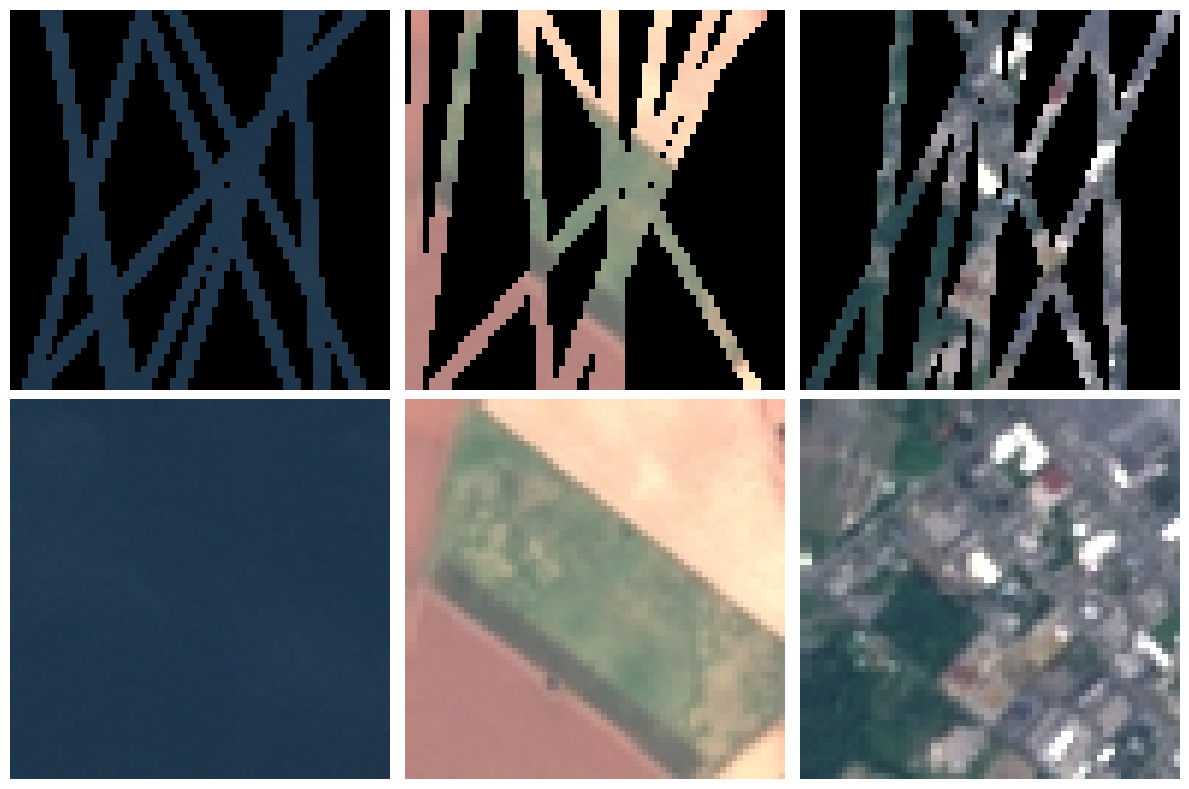

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))  # Adjust figsize as needed
a,b = next(train_generator)
for i in range(3):
  # Plot image on each subplot
  axes[0,i].imshow(a[i])  # Use cmap='gray' if your images are grayscale
  axes[0,i].axis('off')  # Turn off axis
  axes[1,i].imshow(b[i])  # Use cmap='gray' if your images are grayscale
  axes[1,i].axis('off')  # Turn off axis

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

1/1 [==============================] - 0s 178ms/step


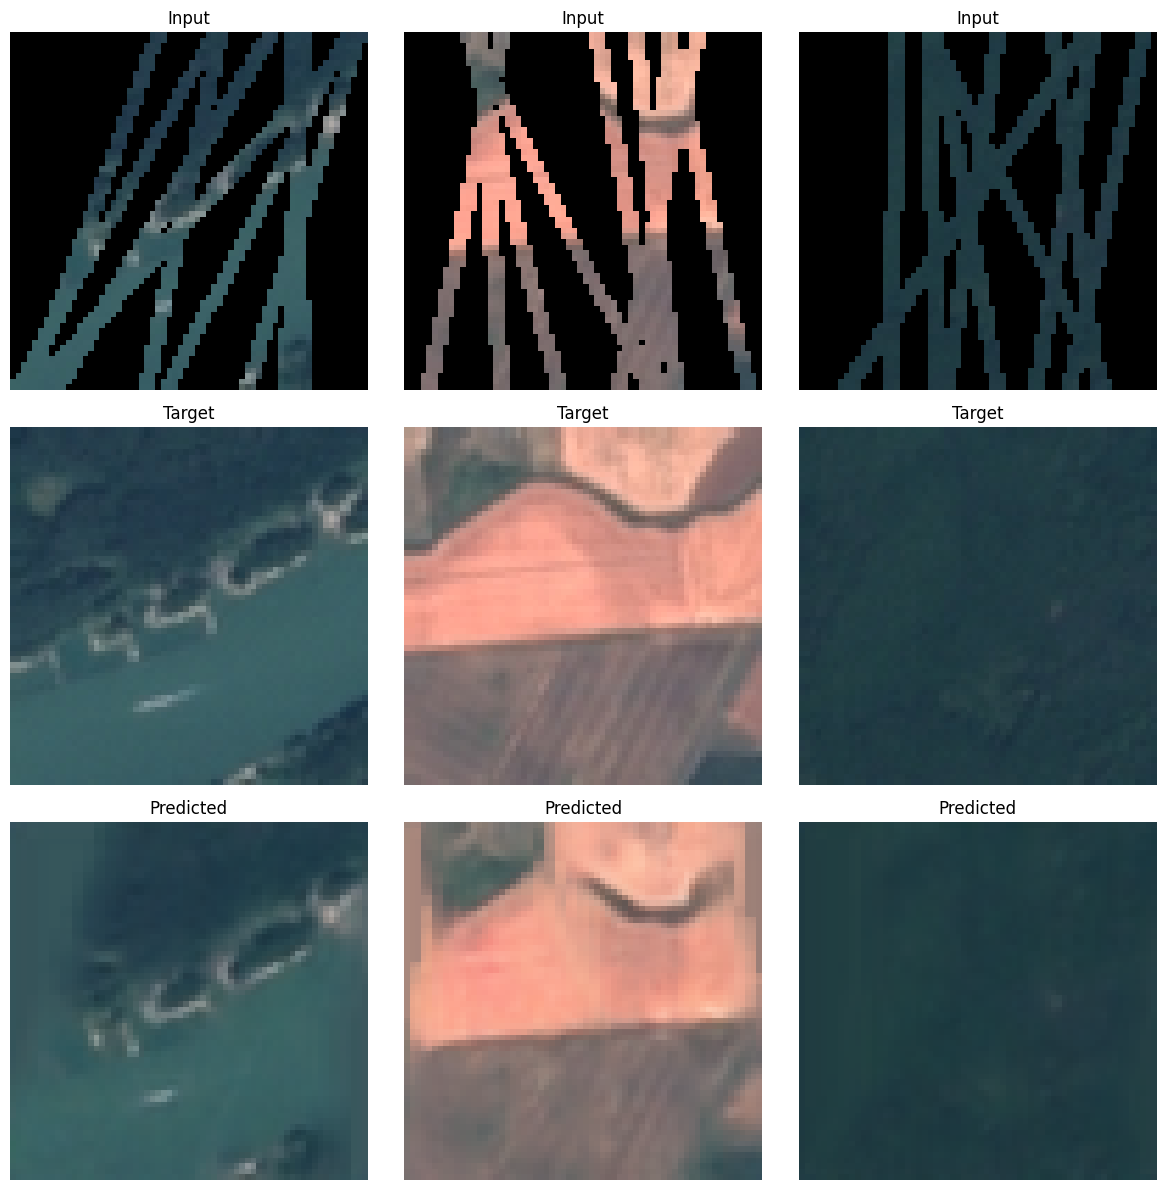

In [ ]:
import matplotlib.pyplot as plt

# Estrai un batch di immagini dal generatore di addestramento
input_images, target_images = next(train_generator)

# Effettua le predizioni utilizzando il tuo modello
predicted_images = inpainting_model.predict(input_images)

# Configura la visualizzazione delle immagini
num_images = min(len(input_images), 3)  # Visualizza al massimo le prime 3 immagini

# Crea una figura con sottoplot
fig, axes = plt.subplots(nrows=3, ncols=num_images, figsize=(12, 12))

for i in range(num_images):
    # Mostra l'immagine originale con la maschera
    axes[0, i].imshow(input_images[i])
    axes[0, i].set_title('Input')
    axes[0, i].axis('off')

    # Mostra l'immagine target (originale senza maschera)
    axes[1, i].imshow(target_images[i])
    axes[1, i].set_title('Target')
    axes[1, i].axis('off')

    # Mostra l'immagine ricostruita dal modello
    axes[2, i].imshow(predicted_images[i])
    axes[2, i].set_title('Predicted')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 27ms/step
Mean MSE: 0.002859408501535654
Standard Deviation of MSE: 0.0011587913613766432


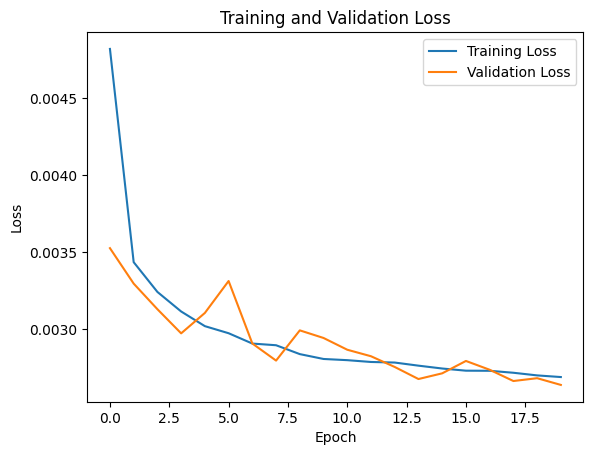

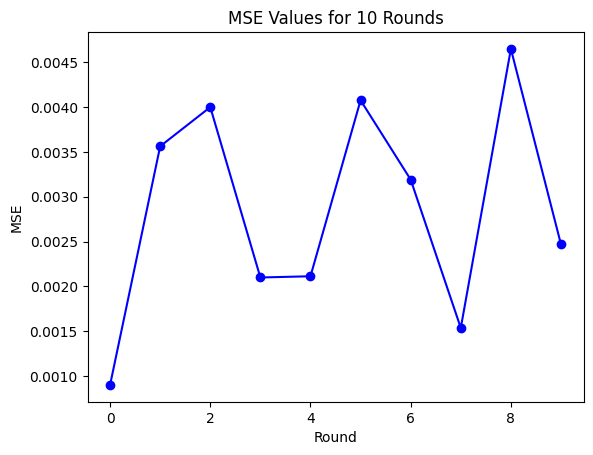

Mean MSE: 0.002859408501535654
Standard Deviation of MSE: 0.0011587913613766432


In [ ]:
# Valutazione delle prestazioni
mse_values = []

# Calcolo degli MSE per 10 round
for _ in range(10):
    test_images, true_images = next(test_generator)
    reconstructed_images = inpainting_model.predict(test_images)

    mse = tf.keras.losses.mean_squared_error(true_images, reconstructed_images).numpy().mean()
    mse_values.append(mse)

# Calcolo del valore medio e della deviazione standard dell'MSE
mean_mse = np.mean(mse_values)
std_dev_mse = np.std(mse_values)

print(f"Mean MSE: {mean_mse}")
print(f"Standard Deviation of MSE: {std_dev_mse}")


# Grafico della loss durante l'addestramento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Grafico degli MSE per i 10 round
plt.plot(mse_values, marker='o', linestyle='-', color='b')
plt.title('MSE Values for 10 Rounds')
plt.xlabel('Round')
plt.ylabel('MSE')
plt.show()

# Calcolo del valore medio e della deviazione standard dell'MSE (ripetuto a fine script)
mean_mse = np.mean(mse_values)
std_dev_mse = np.std(mse_values)

print(f"Mean MSE: {mean_mse}")
print(f"Standard Deviation of MSE: {std_dev_mse}")

